# Основы машинного обучения

## Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

**Цели проекта**:

* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

    1) выделить целевые группы клиентов;
    
    2) предложить меры по снижению оттока;
    
    3) определить другие особенности взаимодействия с клиентами.
    
**План работы**:
1. Провести общий обзор данных.
2. Выполнить предварительную обработку, если это потребуется.
3. Сравнить средние показатели ушедших и оставшихся клиентов.
4. Построить модель, предсказывающую отток клиента.
5. Произвести кластеризацию данных и выделить основные сегменты клиентов.
6. Сформулировать выводы и рекомендации.


Импорт необходимых библиотек:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

## Обзор данных (EDA)

### Импорт и общая сводка

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


**Описание данных**:

Данные клиента за предыдущий до проверки факта оттока месяц:

* `gender` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
* `Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятий;
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* `Churn` — факт оттока в текущем месяце.


In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Вывод**: по результатам предварительного обзора данных установлено, что данные полные и достаточные для построения модели. Пропущенные значения в данных отсутствуют. Типы данных соответсвуют их логическому наполнению. В отток уходит примерно 26.5% клиентов.

**Портрет клиентов**: количество мужчин и женщин распределено примерно пополам, большинство проживает/работает в районе фитнес-центра, примерно половина пользователей пришли по партнерской программе, около 30% пришли по акции "Приведи друга", почти все оставили номер телефона, средняя продолжительность договора - чуть больше 4.5 месяцев, немного меньше половины клиентов посещают групповые занятия, средний возраст около 29 лет, срок до окончания действия договора чуть больше четырех месяцев, средняя выручка - почти 147 у.е., продолжительность посещения чуть менее 4 месяцев с количетвом посещений - 1.5-2 раза в неделю.

### Сравнение средних показателей ушедших и оставшихся клиентов

In [4]:
df_0 = df[df['Churn'] == 0]
df_1 = df[df['Churn'] == 1]

In [5]:
df.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


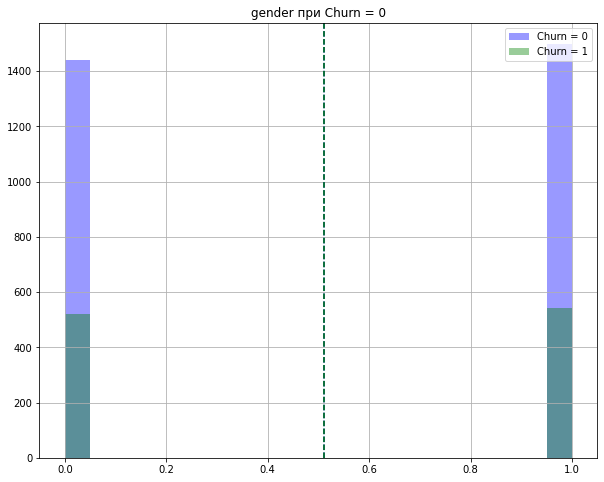

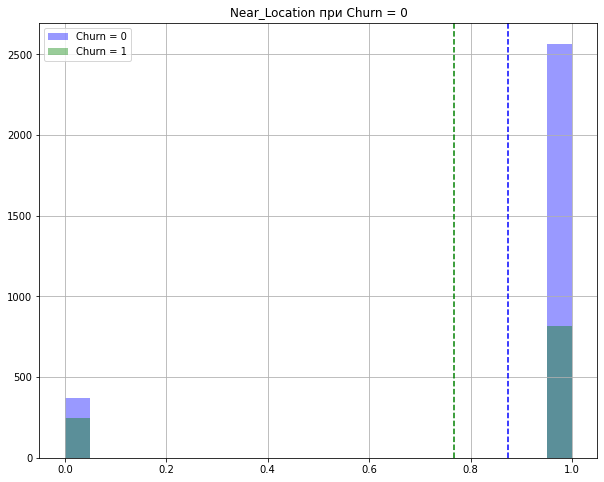

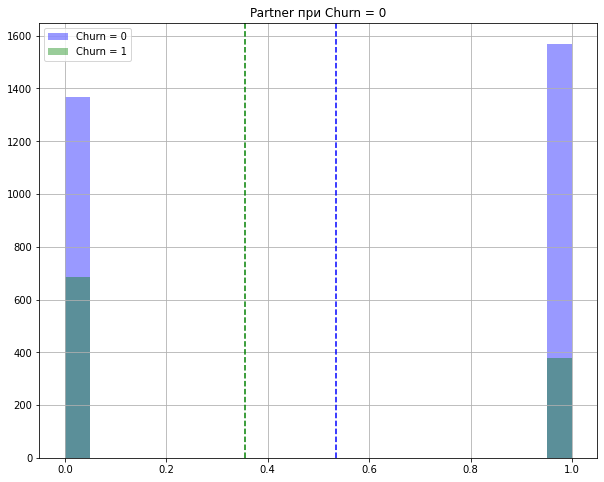

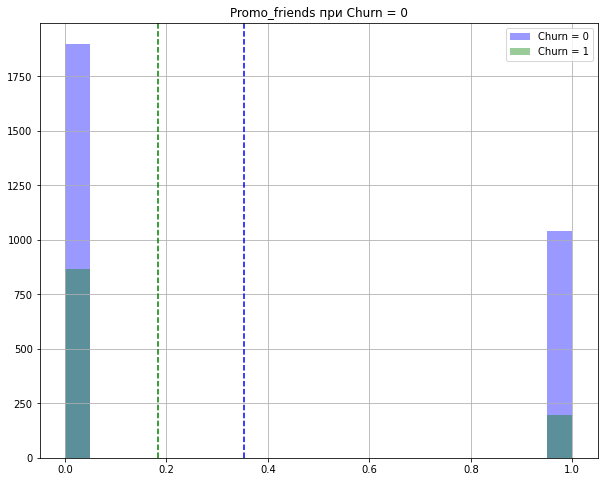

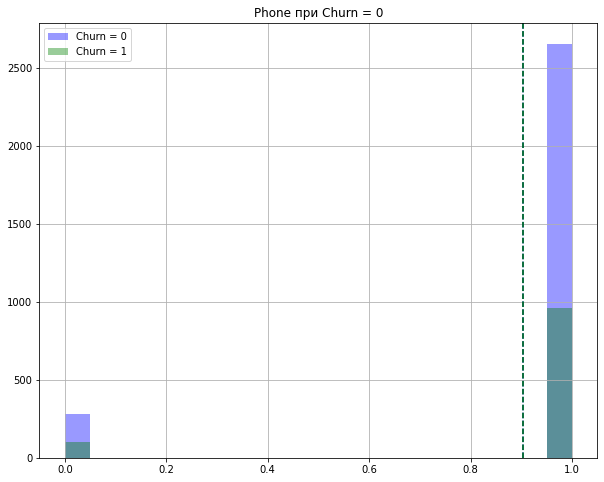

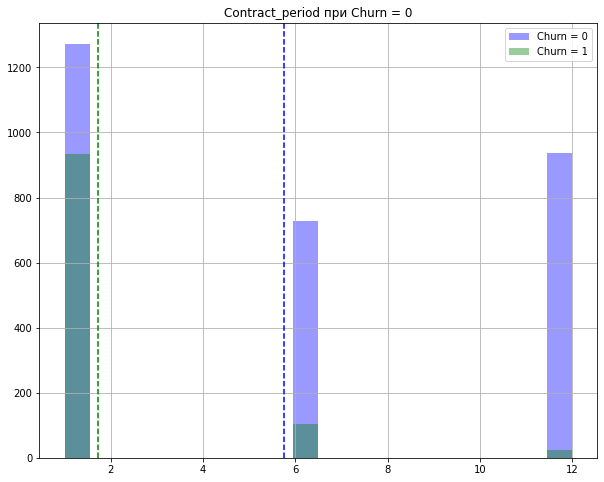

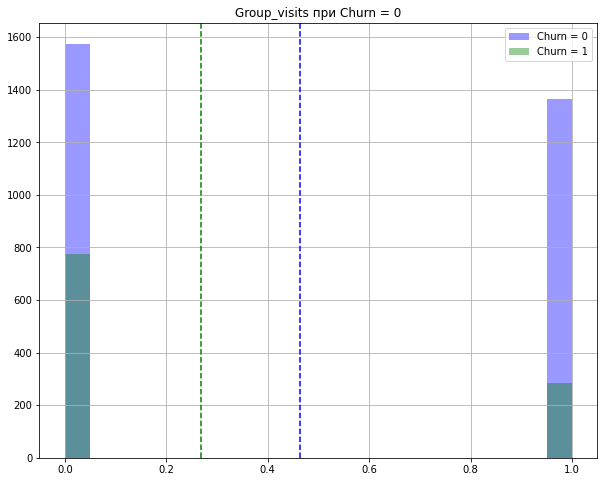

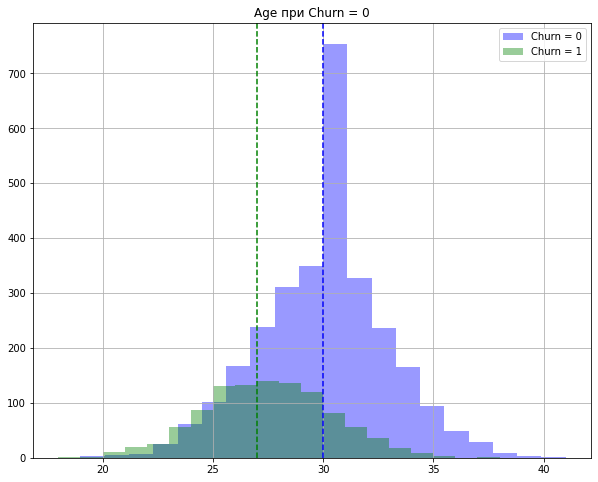

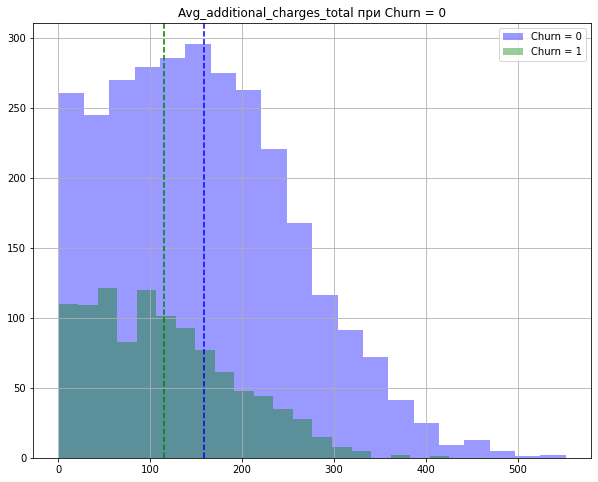

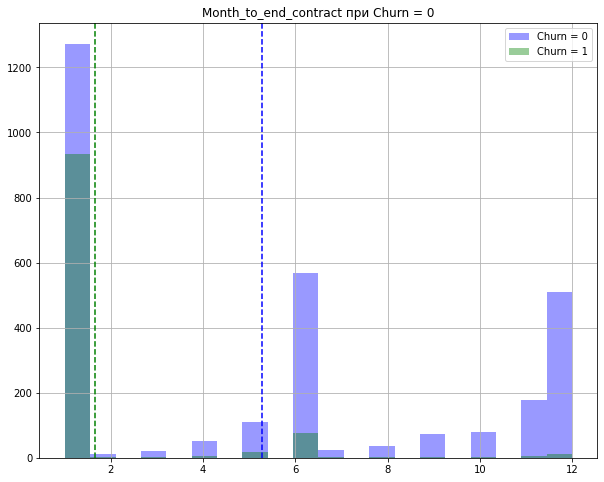

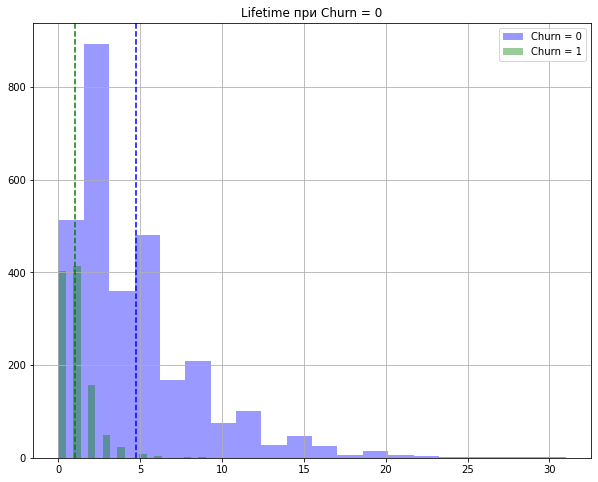

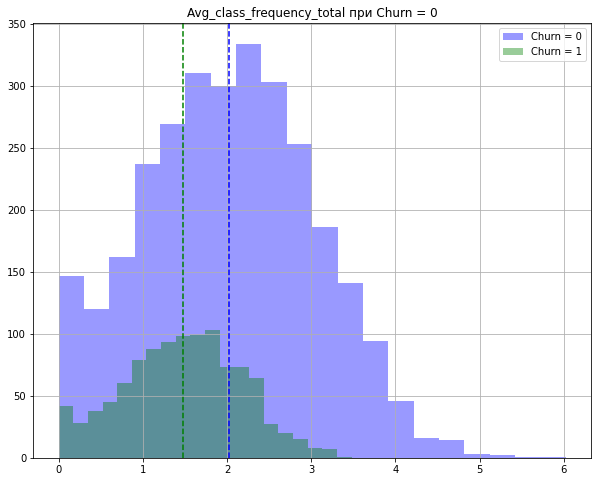

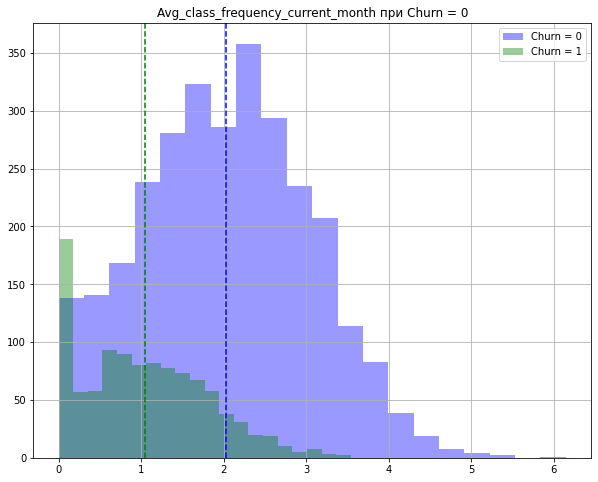

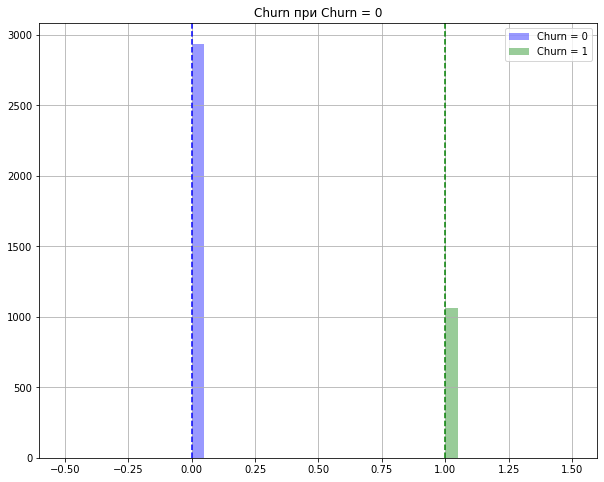

In [6]:
for i in df_0.columns:
    plt.figure(figsize=(10, 8))
    df_0[i].hist(bins=20, alpha = 0.4, label='Churn = 0', color='blue')
    df_1[i].hist(bins=20, alpha = 0.4, label='Churn = 1', color='green')
    text = f'{i} при Churn = 0'
    plt.title(text)
    plt.legend()
    plt.axvline(df_0[i].mean(), color='blue', linestyle='--')
    plt.axvline(df_1[i].mean(), color='green', linestyle='--')
    plt.show()

**Вывод**: по результатам сравнения можно установить, что:
1. Количество мужчин и женщин в обоих группах приблизительно одинаковое.
2. Средняя удаленность от фитнес-клуба у оставшихся клиентов ниже.
3. Оставшиеся клиенты чаще приходили по акции "Приведи друга".
4. Номера телефонов оставляли в среднем одинаково как ушедшие, так и оставшиеся клиенты.
5. У ушедших клиентов в среднем меньше срок действия договора.
6. Ушедшие клиенты реже посещали групповые занятия.
7. Ушедшие клменты в среднем немного моложе оставшихся.
8. Средняя выручка у ушедших клиентов ниже.
9. В среднем договор у ушедших клиентов заканчивается раньше, чем у оставшихся.
10. Лайфтайм ушедших клиентов меньше, чем у оставшихся.
11. Средняя частота посещения в неделю и за прошедший месяц у оставшихся клиентов выше, чем у ушедших.

### Исследование корреляции признаков

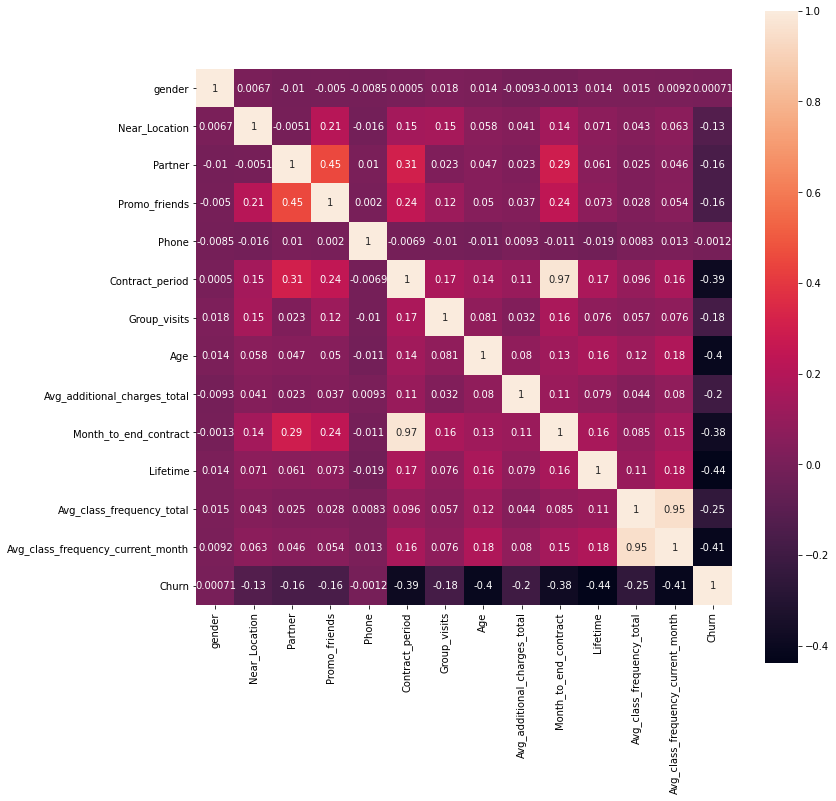

In [7]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True, square=True);
plt.show()

**Вывод**: все признаки слабо коррелируют между собой за исключением:
1. Частоты посещения фитнес-клуба в неделю за прошедший месяц и за всё время.
2. Месяцев до окончания действия договора и периодом договора.

По одному из данных признаков нужно исключить из рассмотрения. Исключим из рассмотрения частоту посещения за последний месяц и период договора (тем более, что формально в рамках задачи данный признак можно расценивать, как категориальный, что немного усложнит дальнейшую процедуру)

## Модель для прогноза оттока клиентов

Формируем набор данных признаков и целевой набор данных:

In [8]:
X = df.drop(['Churn', 'Avg_class_frequency_current_month', 'Contract_period'], axis=1)
y = df['Churn']

Разделяем выборку на обучающую и валидационную:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Сравнивать будем две модели: логистическую регрессию и случайный лес.

In [10]:
m_log = LogisticRegression(random_state=0)
m_log.fit(X_train, y_train);
m_log_predict = m_log.predict(X_test)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
m_rf = RandomForestClassifier(random_state=0)
m_rf.fit(X_train, y_train);
m_rf_predict = m_rf.predict(X_test)

In [12]:
print('Logistic Regression. Accuracy:', accuracy_score(y_test, m_log_predict))
print('Random Forest. Accuracy:',accuracy_score(y_test, m_rf_predict))

print('Logistic Regression. Precision:', precision_score(y_test, m_log_predict))
print('Random Forest. Precision:', precision_score(y_test, m_rf_predict))

print('Logistic Regression. Recall:', recall_score(y_test, m_log_predict))
print('Random Forest. Recall:', recall_score(y_test, m_rf_predict))

Logistic Regression. Accuracy: 0.875
Random Forest. Accuracy: 0.89625
Logistic Regression. Precision: 0.75
Random Forest. Precision: 0.8010471204188482
Logistic Regression. Recall: 0.7424242424242424
Random Forest. Recall: 0.7727272727272727


In [13]:
pd.DataFrame(m_rf.feature_importances_, X.columns)

,0
gender,0.017278
Near_Location,0.012951
Partner,0.017591
Promo_friends,0.016629
Phone,0.009502
Group_visits,0.021375
Age,0.148635
Avg_additional_charges_total,0.133853
Month_to_end_contract,0.123290
Lifetime,0.331463


**Вывод**: в целом, можно заключить, что модель построенная на базе алгоритма случайного леса справляется с поставленной задачей лучше (выше доля правильных ответов, полнота и точность). Настройкой параметров модели, вполне вероятно, можно добиться более высоких результатов, однако в рамках задачи для фитнес-центра данные метрики можно назвать приемлимыми.

## Кластеризация клиентов

Для начала необходимо стандартизировать данные. Воспользуемся алгоритмом StandardScaler.

In [14]:
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

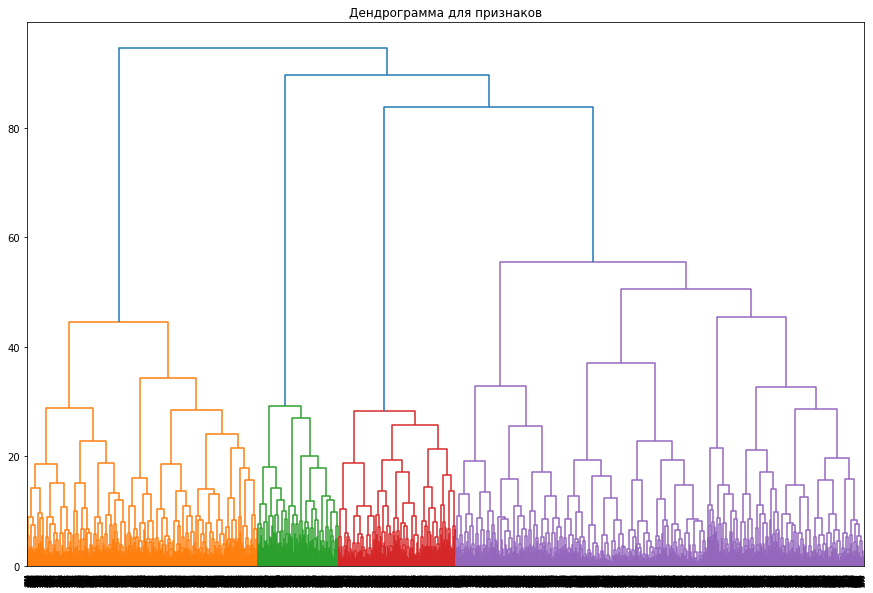

In [15]:
linked = linkage(X_st, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма для признаков')
plt.show() 

**Вывод**: соглашаясь с дендрограммой, я бы установил 4 кластера для представленного набора данных. В соответствии с договоренностью в задании, установим 5 кластеров.

In [16]:
km = KMeans(n_clusters=5, random_state=0)
df['cluster'] = km.fit_predict(X_st)

In [17]:
df.groupby('cluster').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster,,,,,,,,,,,,,,
0,0.498501,0.995005,0.889111,1.000000,1.0,6.844156,0.519481,29.543457,152.139417,6.265734,4.210789,1.951909,1.899338,0.132867
1,0.500898,0.000000,0.488330,0.077199,1.0,2.978456,0.231598,28.685817,137.277472,2.804309,2.978456,1.762672,1.597632,0.402154
2,0.521158,0.995546,0.417595,0.011136,1.0,6.726058,0.546771,30.805122,177.103564,6.162584,5.701559,2.318701,2.314057,0.016704
3,0.512090,1.000000,0.196891,0.053541,1.0,2.012953,0.297064,27.818653,124.625600,1.898964,2.058722,1.539284,1.324365,0.506045
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839


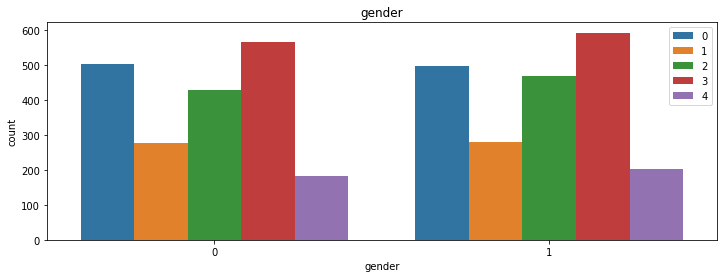

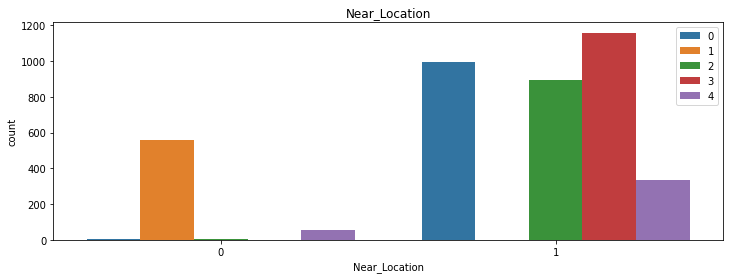

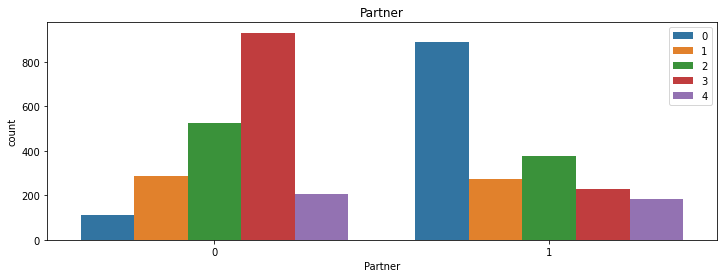

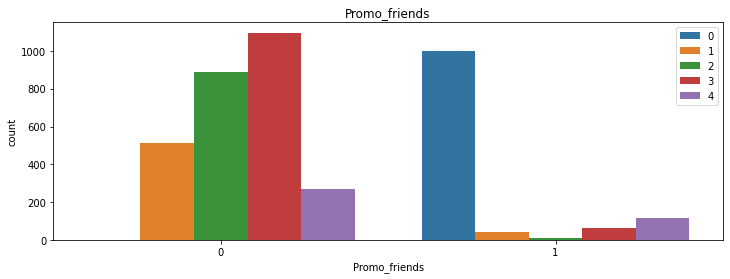

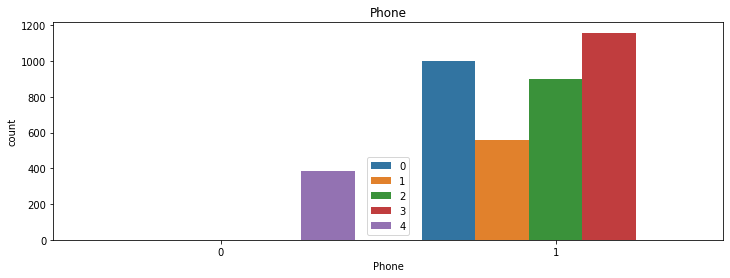

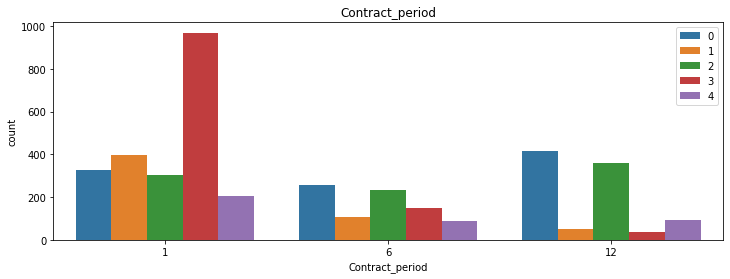

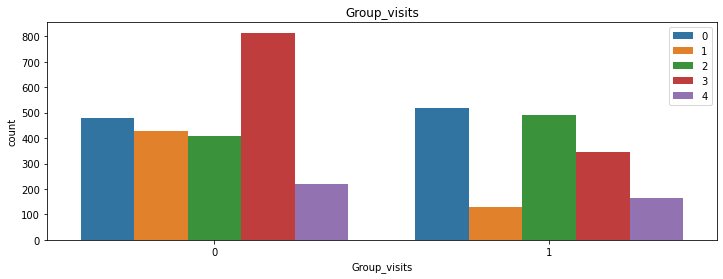

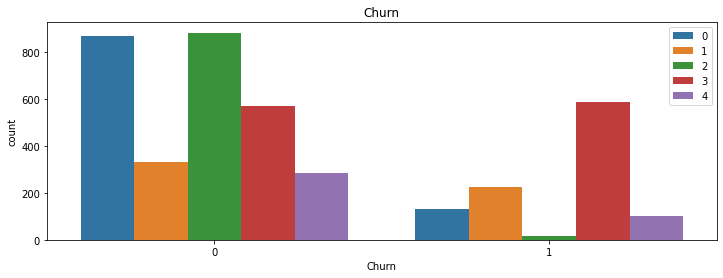

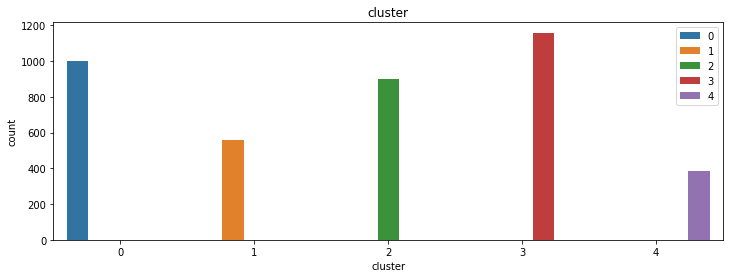

In [18]:
categorical_columns = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Contract_period', 'Group_visits', 'Churn', 'cluster']
for column in categorical_columns:
    plt.figure(figsize=(12, 4))
    sns.countplot(x=df[column], hue="cluster", data=df)
    plt.title(column)
    plt.legend()
    plt.show()

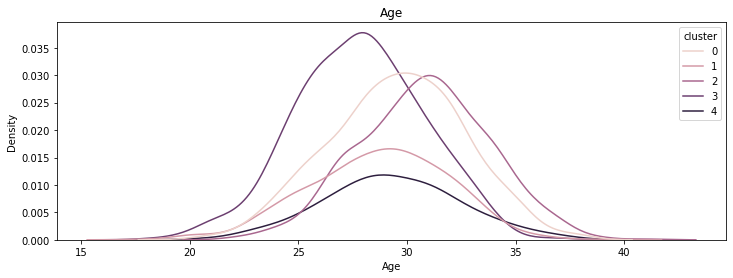

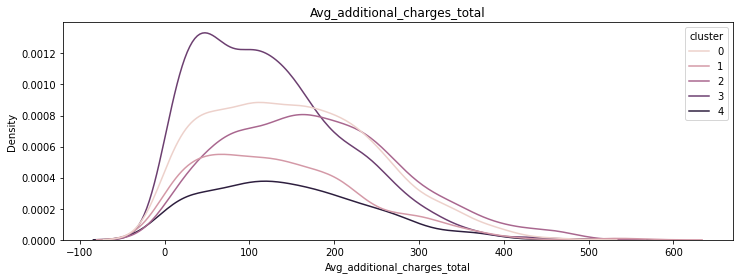

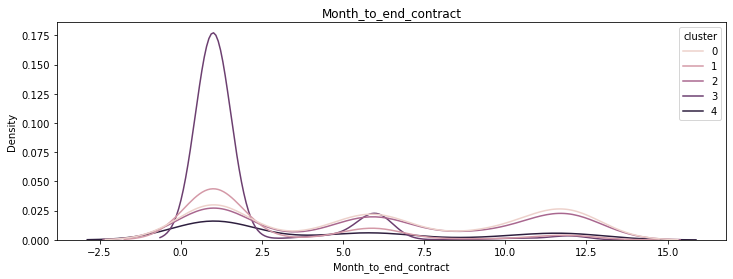

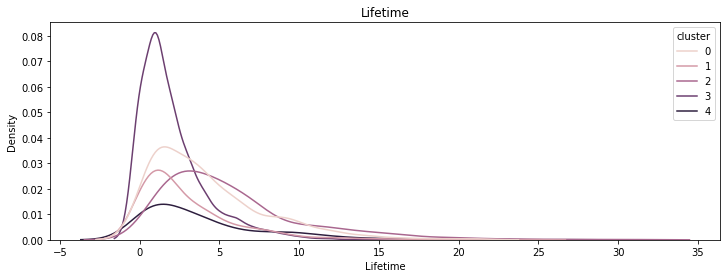

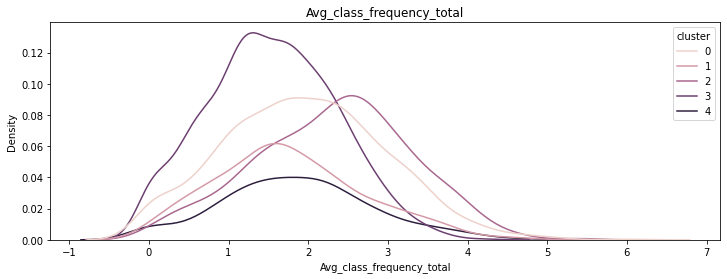

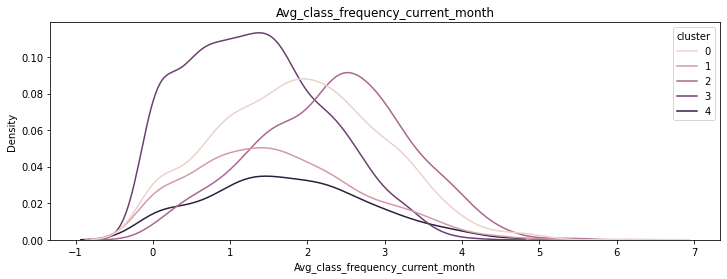

In [19]:
for column in df.drop(categorical_columns, axis=1).columns:
    plt.figure(figsize=(12, 4))
    sns.kdeplot(x=df[column], hue="cluster", data=df, legend=True)
    plt.title(column)
    plt.show()

**Вывод**:

Опишем каждый кластер детально:

**Кластер 0**: клиенты характеризуются низким оттоком, почти все проживают или работают в районе фитнес-цетра, большинство пришли по партнерской программе, все приведены по акции "Приведи друга", все оставили свой номер телефона, средний срок контракта более полугода, примерно половина посещает групповые занятия, приносят высокую выручку относительно других кластеров, до окончания контракта также в среднем более полугода, более 4 месяцев посещают фитнес-центр около 2 раз в неделю. 

**Кластер 1**: почти половина клиентов из данного кластера ушла в отток, никто из клиентов не проживал/не работал в районе фитнес-центра, половина пришла по партнерской программе, почти почти никто не пришёл по акции "Приведи друга", все оставили свой номер мобильного телефона, средняя продолжительность контракта около 3 месяцев, редко посещали групповые занятия, принесли относительно низкую выручку, в среднем около 3 месяцев до окончания контракта, около 3 месяцев посещают фитнес-центр, посещают центр в среднем 1-2 раза в неделю.

**Кластер 2**: **самый низкий отток среди всех представленных кластеров**, почти все проживают или работают в районе фитнес-цетра, около половины пришло по партнерской программе, почти никто не пришёл по акции "Приведи друга", все оставили контактный номер телефона, срок действия договора в среднем более полугода, половина посещает групповые занятия, **самая высокая выручка** среди прочих кластеров, более 6 месяцев до окончания действия договора, около 6 месяцев посещают фитнес центр в среднем более 2 раз в неделю.

**Кластер 3**: **самый высокий отток среди кластеров** (более половины), все проживают или работают в районе фитнес-центра, около 20% пришли по партнерской программе и почти никто не пришёл по акции "Приведи друга", все оставили номер телефона, самая низкая продолжительность договора, около 2 месяцев, около 30% посещают групповые занятия, самая низкая выручка, около 2 месяцев до окончания действия договора, посещают фитнес-центр около 2 месяцев в среднем 1-1.5 раза в неделю.

**Кластер 4**: около 25% клиентов уходит в отток, что можно расценивать как невысокий отток, большинство проживает/работает в районе фитнес-центра, около половины пришло по партнерской программе, и около 30% по акции "Приведи друга", никто не оставил номер телефона, средняя продолжительность договора около 5 месяцев, почти половина посещает групповые занятия, выручка средняя среди всех кластеров, до окончания контракта около 4.5 месяцеы, посещают фитнес-центр около 4 месяцев в среднем 1.5-2 раза в неделю.

**Общее у всех кластеров**: распределение мужчин и женщин приблизительно 50/50, средний возраст от 27 до 31.

## Выводы и рекомендации

В результате работы были выполнены следующие задачи:
* Проведен обзор данных
* Построена модель для прогноза оттока клиентов
* Пользователи были кластеризованы
* По всем разделам сформулированы соответствующие выводы

**Рекомендации**:

В целом, в результате кластеризации были выявлены основные группы клиентов, которые остаются лояльны к фитнес-центру продолжительное время и не прекращают его посещать, принося высокую выручку. Таким образом, в первую очередь необходимо стимулировать увеличение срока действия договора с фитнес-центром среди клиентов, которые проживают/работают в районе фитнес-центра. Затем можно сделать упор на групповые занятия, расширив их количество и добавив новые виды занятий для сохранения интереса клиентов. Так как самые лояльные и "дорогостоящие" клиенты как правило, посещают фитнес-центр чаще других, можно улучшить условия (комфорт) внутри фитнес-центра (например, своевременное обновление тренажеров, поддержание чистоты в раздевалках итд). При всех вышеуказанных условиях нужно развивать партнерскую сеть с упором на долгосрочное сотрудничество с каждым клиентом. При этом, возможно, стоит сократить объем краткосрочных договоров, так как это самые уходящие клиенты. При этом стоит отдельно исследовать, почему клиенты не задерживаются надолго и избавиться от этих факторов, если это экономически целесообразно.